In [9]:
#Load all libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

In [10]:
# Load cleaned dataset
df = pd.read_csv("../Data Cleaning/Processed/final_dataset.csv")

print("Shape:", df.shape)
df.head()

Shape: (14004, 42)


,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,nsmiles,passengers,fare,carrier_lg,...,orig_overseas_visitation_2023,dest_state_name,dest_overseas_share_2024,dest_overseas_visitation_2024,dest_overseas_change_2024_vs_2023,dest_overseas_share_2023,dest_overseas_visitation_2023,fare_per_mile,dominance_bucket,lcc_bucket
0,2022,1,30135,34761,"Allentown/Bethlehem/Easton, PA","Sanford, FL",882,376.0,102.49,G4,...,843000.0,Florida,0.2520,8860000.0,0.117,0.2521,7933000.0,0.116202,dominated,high_lcc
1,2022,1,30140,30194,"Albuquerque, NM","Dallas/Fort Worth, TX",580,464.0,178.62,AA,...,85000.0,Texas,0.0594,2088000.0,0.115,0.0595,1872000.0,0.307966,moderate,high_lcc
2,2022,1,30140,30325,"Albuquerque, NM","Denver, CO",349,323.0,142.07,WN,...,85000.0,Colorado,0.0131,461000.0,-0.011,0.0148,466000.0,0.407077,moderate,high_lcc
3,2022,1,30140,30423,"Albuquerque, NM","Austin, TX",619,218.0,169.01,WN,...,85000.0,Texas,0.0594,2088000.0,0.115,0.0595,1872000.0,0.273037,moderate,high_lcc
4,2022,1,30140,30466,"Albuquerque, NM","Phoenix, AZ",328,481.0,165.33,WN,...,85000.0,Arizona,0.0330,1160000.0,0.233,0.0299,941000.0,0.504055,dominated,high_lcc


Data cleaning
- Drop rows with missing key variables
- Force all variables to be numeric
- Clip market share to be 0 and 1
- Create new variables: fare_per_mile and time_index

In [11]:

d = df.dropna(subset=["fare","nsmiles","passengers","large_ms","lf_ms"]).copy()

cols = ["fare","nsmiles","passengers","large_ms","lf_ms"]
for c in cols:
    d[c] = pd.to_numeric(d[c], errors="coerce")

d["large_ms"] = d["large_ms"].clip(0,1)
d["lf_ms"] = d["lf_ms"].clip(0,1)

d["fare_per_mile"] = d["fare"] / d["nsmiles"]
d["time_index"] = d["Year"]*4 + d["quarter"]

print("Cleaned shape:", d.shape)
d.info()

Cleaned shape: (14004, 43)
<class 'pandas.DataFrame'>
RangeIndex: 14004 entries, 0 to 14003
Data columns (total 43 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Year                               14004 non-null  int64  
 1   quarter                            14004 non-null  int64  
 2   citymarketid_1                     14004 non-null  int64  
 3   citymarketid_2                     14004 non-null  int64  
 4   city1                              14004 non-null  str    
 5   city2                              14004 non-null  str    
 6   nsmiles                            14004 non-null  int64  
 7   passengers                         14004 non-null  float64
 8   fare                               14004 non-null  float64
 9   carrier_lg                         14004 non-null  str    
 10  large_ms                           14004 non-null  float64
 11  fare_lg                            140

Feature Engineering
- log transformation for variables
- create net power and comp strength index to interpret dominance and competitiveness

In [13]:
import numpy as np

d["log_fare"] = np.log(d["fare"])
d["log_distance"] = np.log(d["nsmiles"])
d["log_passengers"] = np.log(d["passengers"] + 1)

In [14]:
d["market_power_index"] = d["large_ms"] - d["lf_ms"]
d["competition_strength"] = 1 - d["large_ms"]


Hub: This feature measures how strongly a route is connected to major airline hubs, capturing structural pricing power beyond simple competition metrics. Helps evaluate market power that is not captured by market share alone.

In [17]:
city_pax = (
    d.groupby("city1")["passengers"].sum()
    + d.groupby("city2")["passengers"].sum()
)

hub_threshold = city_pax.quantile(0.90)
hub_cities = set(city_pax[city_pax >= hub_threshold].index)

d["hub_intensity"] = (
    d["city1"].isin(hub_cities).astype(int)
    + d["city2"].isin(hub_cities).astype(int)
)

Fair premium vs discount: Measures how much a route’s fare exceeds what we would expect based purely on distance. It important cus it helps isolate price beyond cost, it represents a strong fairness and marketing indicator.

Passenger density: Measure demand intensity per mile. It help tests whether busy short routes command higher prices (demand-based pricing).

Time: Improves interpretability of time effects in regression.

In [ ]:
baseline = smf.ols("fare ~ nsmiles", data=d).fit()
d["distance_adjusted_fare"] = baseline.resid
d["passenger_density"] = d["passengers"] / d["nsmiles"]
d["years_since_2021"] = d["Year"] - 2021

<Axes: xlabel='fare', ylabel='Count'>

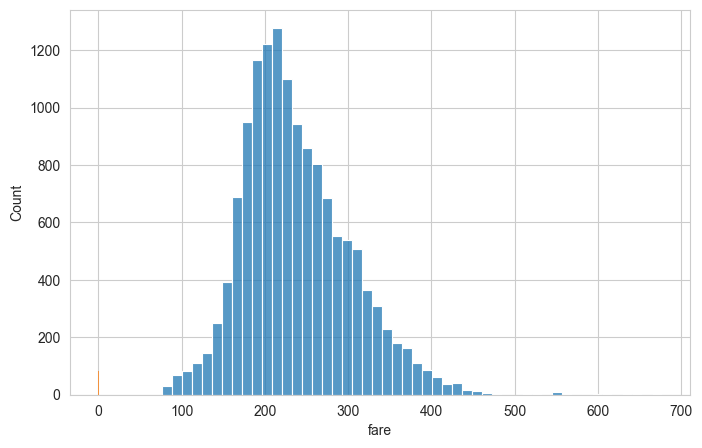

In [19]:
d[["fare","nsmiles","passengers","large_ms","lf_ms"]].describe()
sns.histplot(d["fare"], bins=50)
sns.histplot(d["large_ms"], bins=30)

<Axes: xlabel='nsmiles', ylabel='fare'>

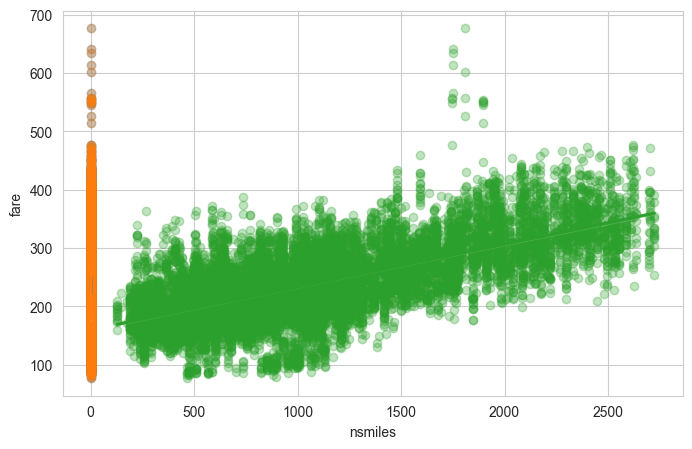

In [20]:
sns.regplot(data=d, x="large_ms", y="fare", scatter_kws={"alpha":0.3})
sns.regplot(data=d, x="lf_ms", y="fare", scatter_kws={"alpha":0.3})
sns.regplot(data=d, x="nsmiles", y="fare", scatter_kws={"alpha":0.3})

<Axes: xlabel='log_fare', ylabel='Count'>

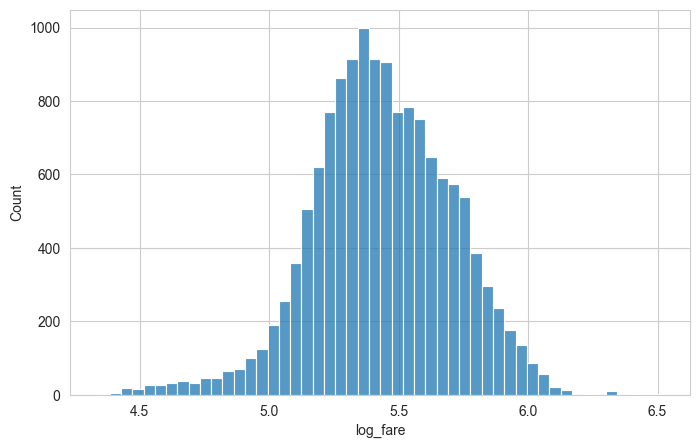

In [22]:
sns.histplot(d["log_fare"], bins=50)

In [23]:
d = d[d["nsmiles"] > 0]
d["log_distance"] = np.log(d["nsmiles"])
d["log_fare"] = np.log(d["fare"])

In [24]:
smf.ols("log_fare ~ log_distance", data=d).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_fare   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     7361.
Date:                Sat, 28 Feb 2026   Prob (F-statistic):               0.00
Time:                        17:24:12   Log-Likelihood:                 1406.2
No. Observations:               14004   AIC:                            -2808.
Df Residuals:                   14002   BIC:                            -2793.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.5980      0.021    167.412      0.000       3.556       3.640
log_distance     0.2699      0.003     85.798      0.000       0.264       0.276
==============================================================================
Omnibus:                     1619.144   Durbin-Watson:                   1.530
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3406.894
Skew:                          -0.723   Prob(JB):                         0.00
Kurtosis:                       4.936   Cond. No.                         81.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Distance explains 34.5% of airfare variation.

That means: 65% of fare variation is driven by:
	Competition
	Demand
	Hub structure
	Time effects
	Market power


In [25]:
m_full = smf.ols(
    "log_fare ~ log_distance + log_passengers + large_ms + lf_ms + hub_intensity + C(Year)",
    data=d
).fit(cov_type="HC3")

m_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_fare   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     1483.
Date:                Sat, 28 Feb 2026   Prob (F-statistic):               0.00
Time:                        17:26:51   Log-Likelihood:                 2619.4
No. Observations:               14004   AIC:                            -5221.
Df Residuals:                   13995   BIC:                            -5153.
Df Model:                           8                                         
Covariance Type:                  HC3                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.1235      0.032    128.918      0.000       4.061       4.186
C(Year)[T.2023]     0.0154      0.005      3.384      0.001       0.006       0.024
C(Year)[T.2024]     0.0288      0.005      6.364      0.000       0.020       0.038
C(Year)[T.2025]     0.0486      0.006      8.547      0.000       0.037       0.060
log_distance        0.2569      0.003     78.482      0.000       0.251       0.263
log_passengers     -0.0622      0.002    -31.638      0.000      -0.066      -0.058
large_ms            0.0841      0.014      5.986      0.000       0.057       0.112
lf_ms              -0.3518      0.011    -32.744      0.000      -0.373      -0.331
hub_intensity       0.0227      0.004      6.426      0.000       0.016       0.030
==============================================================================
Omnibus:                     1219.568   Durbin-Watson:                   1.531
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2160.997
Skew:                          -0.621   Prob(JB):                         0.00
Kurtosis:                       4.469   Cond. No.                         164.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

Airfare pricing is driven by cost, competition, and network structure

Distance explains a substantial portion of fare variation (≈35%), but once competition, demand, hub exposure, and time effects are included, explanatory power rises to 45%. This indicates that structural market factors meaningfully shape airfare outcomes.

Routes with higher dominant-carrier market share charge higher prices, while greater low-cost carrier penetration significantly reduces fares. In fact, low-cost competition has a stronger price-reducing effect than dominant share has a price-increasing effect.

Hub exposure also adds pricing power: routes connected to major hubs are systematically more expensive, even after controlling for distance and demand.

Post-pandemic trends show fares rising over time, suggesting structural upward pressure beyond cost fundamentals.

Overall, airfare markets are not purely cost-driven — they reflect measurable market power, competitive dynamics, and network structure.

Our analysis shows that airfares are not primarily driven by distance alone, challenging the common belief that “longer flights simply cost more.” While distance explains about one-third of fare variation, nearly half of pricing differences are explained once competition, hub exposure, demand, and post-pandemic trends are considered. Routes dominated by a single major airline charge systematically higher fares, while greater low-cost carrier presence significantly reduces prices—often by a larger magnitude than dominance increases them. Additionally, hub-to-hub routes carry a measurable pricing premium, suggesting structural network power beyond route-level competition. Together, these findings reveal that affordability is shaped less by geography and more by competitive structure, meaning students and families traveling in less competitive or hub-heavy markets face systemic price disadvantages.